# Nhóm 4

### 22120116 - Đoàn Gia Huệ
### 22120352 - Phạm Nguyễn Quang Thoại
### 22120380 - Hồ Nhất Trí 

## Phase 1

In [6]:
import sys
sys.executable

'c:\\Program Files\\Python313\\python.exe'

## Nhập Thư Viện Cần Thiết

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay

## Mở Dữ Liệu Huấn Luyện

In [8]:
with open("train.json", "r") as f:
    train_data = json.load(f)

X = [item["audio_embedding"] for item in train_data]
y = [item["is_turkey"] for item in train_data]

## Tiền Xử Lý Dữ Liệu

In [9]:
frame_counts = []

for i, item in enumerate(X):
    num_frames = len(item)
    frame_counts.append(num_frames)

print(f"Tổng số mẫu: {len(X)}")
print(f"Số frame tối thiểu trong một mẫu: {min(frame_counts)}")
print(f"Số frame tối đa trong một mẫu: {max(frame_counts)}")
print(f"Số frame trung bình mỗi mẫu: {sum(frame_counts) / len(frame_counts):.2f}")


Tổng số mẫu: 1195
Số frame tối thiểu trong một mẫu: 2
Số frame tối đa trong một mẫu: 10
Số frame trung bình mỗi mẫu: 9.87


- Ta nhận thấy số frame trong các mẫu không giống nhau, dẫn đến kích thước đặc trưng đầu vào không đồng nhất giữa các mẫu, gây khó khăn khi xây dựng mô hình học máy. Vì vậy cần có bước chuẩn hóa dữ liệu đầu vào để mỗi mẫu có kích thước giống nhau.
- Hàm `pad_embedding` giúp chuẩn hóa độ dài của mỗi mẫu audio_embedding sao cho tất cả các mẫu đều có cùng số frame (max_frames bằng 10, là số frame tối đa trong một mẫu)

In [10]:
max_frames = max(len(emb) for emb in X)

def pad_embedding(embedding, max_len=max_frames, dim=128):
    length = len(embedding)
    if length < max_len:
        padding = [[0]*dim] * (max_len - length)
        return embedding + padding
    else:
        return embedding[:max_len]
    

Tiến hành chuẩn hóa lại dữ liệu huấn luyện

In [11]:
X_padded = [pad_embedding(emb) for emb in X]

# Xây Dựng Mô Hình

Chia tập dữ liệu huấn luyện thành 2 tập: train và validation với tỷ lệ 8:2

In [12]:
X_train_pad, X_val_pad, y_train, y_val = train_test_split(
    X_padded, y, test_size=0.2, random_state=42, stratify=y
)

Chuẩn bị dữ liệu đúng định dạng cho mô hình học máy

In [13]:
X_train_pad = np.array(X_train_pad)
X_val_pad = np.array(X_val_pad)


X_train_flat = X_train_pad.reshape(len(X_train_pad), -1)
X_val_flat = X_val_pad.reshape(len(X_val_pad), -1)

Khởi tạo mô hình SVM, huấn luyện và dự đoán

In [14]:
clf = svm.SVC(kernel='linear')

clf.fit(X_train_flat, y_train)

y_pred = clf.predict(X_val_flat)

## Đánh Giá Mô Hình

In [15]:
print("Accuracy:", accuracy_score(y_val, y_pred))

Accuracy: 0.9205020920502092


In [16]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       141
           1       0.93      0.87      0.90        98

    accuracy                           0.92       239
   macro avg       0.92      0.91      0.92       239
weighted avg       0.92      0.92      0.92       239



In [17]:
print(confusion_matrix(y_val, y_pred))

##    [[TN  FP]
##    [FN  TP]]

[[135   6]
 [ 13  85]]


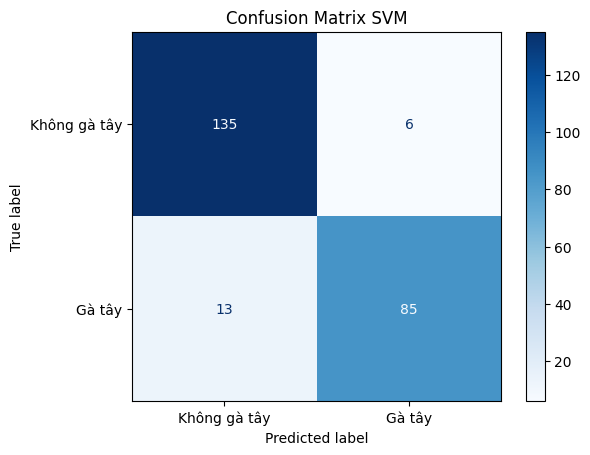

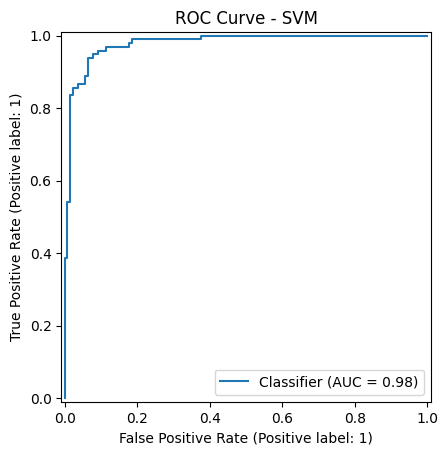

In [24]:
# ma trận nhầm lẫn 
# Giúp xem mô hình dự đoán đúng/sai bao nhiêu mẫu theo từng lớp:
cm_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred, display_labels=["Không gà tây", "Gà tây"], cmap=plt.cm.Blues)
plt.title("Confusion Matrix SVM")
plt.show()


# Đường cong ROC (ROC Curve)
# Đánh giá khả năng phân biệt giữa 2 lớp theo xác suất đầu ra:
clf = svm.SVC(kernel='linear', probability=True)  # Bật chế độ xác suất
clf.fit(X_train_flat, y_train)
y_pred_proba = clf.predict_proba(X_val_flat)[:, 1]  # Xác suất của lớp "có gà tây"

RocCurveDisplay.from_predictions(y_val, y_pred_proba)
plt.title("ROC Curve - SVM")
plt.show()



## Dự Đoán Trên Tập TEST Và In Kết Quả Ra File CSV

In [ ]:
# DỰ ĐOÁN TRÊN X_TEST
with open("data/test.json", "r") as f:
    test_data = json.load(f)

X_test = [item["audio_embedding"] for item in test_data]
X_test_id = [item["vid_id"] for item in test_data]

X_test_padded = [pad_embedding(emb) for emb in X_test]

X_test_padded = np.array(X_test_padded)
X_test_flat = X_test_padded.reshape(len(X_test_padded), -1)

test_pred = clf.predict(X_test_flat)

for i in range(len(test_pred)):
    print(X_test_id[i],": ",test_pred[i])


In [ ]:
df = pd.DataFrame({
    'vid_id': X_test_id,
    'is_turkey': test_pred
})

df.to_csv('submission.csv', index=False, encoding='utf-8')